In [1]:
import torch
import torch.autograd as autograd        
from torch import Tensor                  
import torch.nn as nn                     
import torch.optim as optim               

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
# from sklearn.model_selection import train_test_split

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

## Paramètres

In [3]:
steps = 10000
lr = 1e-3
layers = np.array([1,50,50,20,50,50,1]) #5 hidden layers
# To generate new data:
mini = 0
maxi = 1
total_points = 500
#Nu: Number of training points (2 as we onlt have 2 boundaries), # Nf: Number of collocation points (Evaluate PDE)
Nu = 2
Nf = 250

## Équations

$$ \Phi = -\dfrac{GM}{r + a} $$ 
donc $$\Phi' = \Phi \times \dfrac{a}{GM} = -\dfrac{a}{r + a} = -\dfrac{1}{s + 1}$$
Conditions aux bords:
$$ \Phi(s=0) = - 1$$
$$ \Phi(s=1) = \dfrac{1}{2}$$

In [4]:
def min_max_scalar(x: float, origin_interval: tuple,  arrival_interval: tuple) -> float:
    """Scales a scalar from the interval [c, d] to the interval [a, b]"""
    c, d = origin_interval
    _a, b = arrival_interval
    return ((x - c) / (d - c)) * (b - _a) + _a

In [5]:
from potentials import hernquist
def f_BC(x):
    return -hernquist(x)
     #return min_max_scalar(real_value, (-1, -0.5), (0, 1))
def f_real(x):
    return -hernquist(x)
    # return min_max_scalar(real_value, (-1, -0.5), (0, 1))
def PDE(x):
    return -2 * x / (x + 1) ** 3

In [6]:
class FCN(nn.Module):
    def __init__(self,layers):
        super().__init__()
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) 
        self.iter = 0
        'Xavier Normal Initialization'
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            
            # weights from a normal distribution with 
            # Recommended gain value for tanh = 5/3?
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   

    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        _a = x.float()
        for i in range(len(layers)-2):  
            z = self.linears[i](_a)              
            _a = self.activation(z)    
        _a = self.linears[-1](_a)
        return torch.abs(_a)

    def lossBC(self,x_BC,y_BC):
        border_values = self.forward(x_BC)
        # border_values = min_max_scalar(border_values, (-1, -0.5), (0, 1))
        # y_BC = min_max_scalar(y_BC, (-1, -0.5), (0, 1))
        loss_BC = self.loss_function(border_values,y_BC)

        return loss_BC

    def lossPDE(self,x_PDE):
        g = x_PDE.clone()
        g.requires_grad = True 
        f = self.forward(g)
        # f = (f - f.min())/(f.max() - f.min())
        f_x = torch.autograd.grad(f, g,
                                   grad_outputs=torch.ones([x_PDE.shape[0],1]),
                                   create_graph=True,
                                   retain_graph=True, )[0]
        u_x = f_x * g ** 2
        u_xx = torch.autograd.grad(u_x, g, grad_outputs=torch.ones([x_PDE.shape[0],1]), create_graph=True, retain_graph=True,)[0]

        return self.loss_function(u_xx,PDE(g))
      
    def loss(self,x_BC,y_BC,x_PDE):
        loss_bc = self.lossBC(x_BC, y_BC)
        loss_pde = self.lossPDE(x_PDE)
        return loss_bc + loss_pde

## Génération données

In [7]:
# get the analytical solution over the full domain
# a = 1
x = torch.linspace(mini,maxi,total_points).view(-1,1) #prepare to NN
y = f_real(x)
print(x.shape, y.shape)

torch.Size([500, 1]) torch.Size([500, 1])


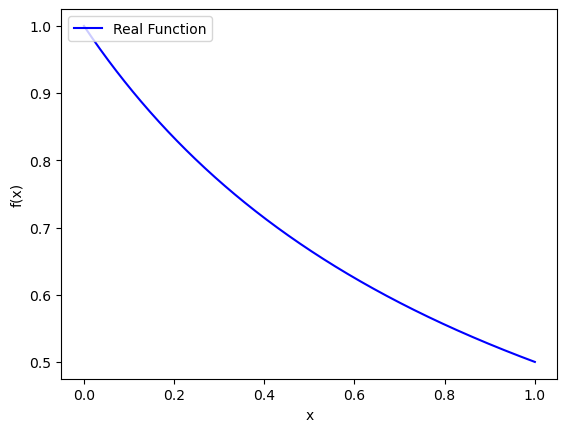

In [8]:
fig, ax1 = plt.subplots()
ax1.plot(x.detach().numpy(),y.detach().numpy(),color='blue',label='Real Function')
#ax1.plot(x_train.detach().numpy(),yh.detach().numpy(),color='red',label='Pred_Train')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('f(x)',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper left');

In [9]:
#Nu: Number of training point, # Nf: Number of colloction points
# Set Boundary conditions x=min & x= max
BC_1 = x[0,:]
BC_2 = x[-1,:]
# Total Tpaining points BC1+BC2
all_train=torch.vstack([BC_1, BC_2])
#Select Nu points
idx = np.random.choice(all_train.shape[0], Nu, replace=False) 
x_BC = all_train[idx]
#Select Nf points
# Latin Hypercube sampling for collocation points 
x_PDE = BC_1 + (BC_2 - BC_1) * lhs(1, Nf)  # lhs: latin hypercube sampling de pyDOE
x_PDE = torch.vstack((x_PDE,x_BC)) 

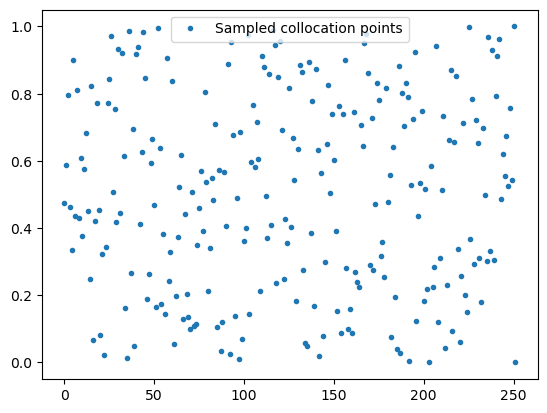

In [10]:
plt.plot(x_PDE, '.', label="Sampled collocation points")
plt.legend();

In [11]:
y_BC = f_BC(x_BC)

## Entraînement du réseau

In [12]:
torch.manual_seed(123)
#Create Model
model = FCN(layers)
print(model)

params = list(model.parameters())
optimizer = torch.optim.Adam(model.parameters(),lr=lr, amsgrad=False)
start_time = time.time()

FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=1, bias=True)
  )
)


In [13]:
model.lossBC(x_BC,y_BC)

tensor(0.5698, grad_fn=<MseLossBackward0>)

In [14]:
for i in range(steps):
    yh = model(x_PDE)
    loss = model.loss(x_BC,y_BC,x_PDE)# use mean squared error
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%(steps/10)==0:
        print(loss)

tensor(0.7077, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1.7653e-05, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(8.5061e-06, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2.9669e-06, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4.2707e-06, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4.0390e-07, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4.4459e-07, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(5.2276e-07, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(4.8328e-07, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(6.3755e-07, dtype=torch.float64, grad_fn=<AddBackward0>)


## Graphes

In [15]:
yh = model(x)
y = f_real(x)
#Error
print(model.lossBC(x,f_real(x)))

tensor(1.8288e-07, grad_fn=<MseLossBackward0>)


In [16]:
# Detach from GPU
y_plot = y.detach().numpy()
yh_plot = yh.detach().numpy()

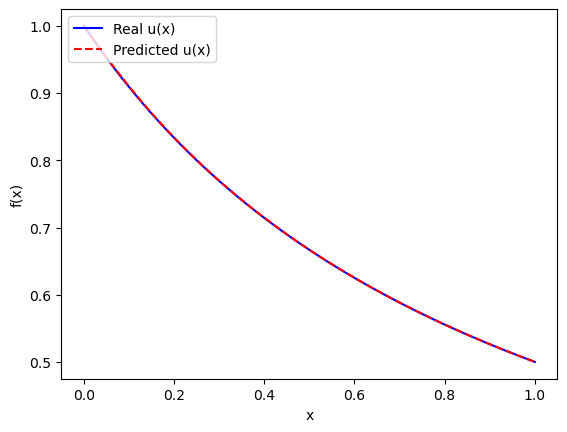

In [17]:
# Plot
fig, ax1 = plt.subplots()
ax1.plot(x,y_plot,color='blue',label='Real u(x)')
ax1.plot(x,yh_plot,'--r',label='Predicted u(x)')
# ax1.plot(x,f_x_plot,color='green',label='Computed u\'(x)')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('f(x)',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper left');

## Vérification

In [18]:
def validation_loss(y_pred, y_true, _type="L2-norm"):
    absolute_error = abs(y_pred - y_true)
    if _type == "L2-norm":
        return absolute_error ** 2
    else:
        print("L2-norm not chosen. Using default L1-norm")
        return absolute_error

In [30]:
def plot_prediction_and_loss(a, figsize=(15, 5), save=False):
    x = torch.linspace(0, 1, 10000, requires_grad=False) * a
    x = x.reshape(-1, 1)
    prediction = -model(x).detach().numpy()
    true_value = hernquist(x).detach().numpy()
    loss = validation_loss(prediction, true_value)
    
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(f"Hernquist potential and associated loss for {a=:.1f}")
    #axs[0].set_title(f"Hernquist potential, {a=}")
    axs[0].plot(x, prediction, '--r', label="Predicted Value")
    axs[0].plot(x, true_value, label="Analytical Value")
    axs[0].set_xlabel("Domain ($r$)")
    axs[0].set_ylabel(r"$\Phi(r)$")
    # plt.legend()
    # plt.savefig(f"resultats/prediction_hq_{a=}.jpg")

    #axs[1].set_title(f"Validation loss for {a=}")
    axs[1].set_xlabel(r"Domain ($r$)")
    axs[1].set_ylabel(r"Loss $\mathcal{L}$")
    axs[1].plot(x, loss)
    axs[0].legend(loc = 'lower right');
    if save:
        plt.savefig(f"resultats/hq_{a=}.jpg")
    plt.show()
    #plt.close()

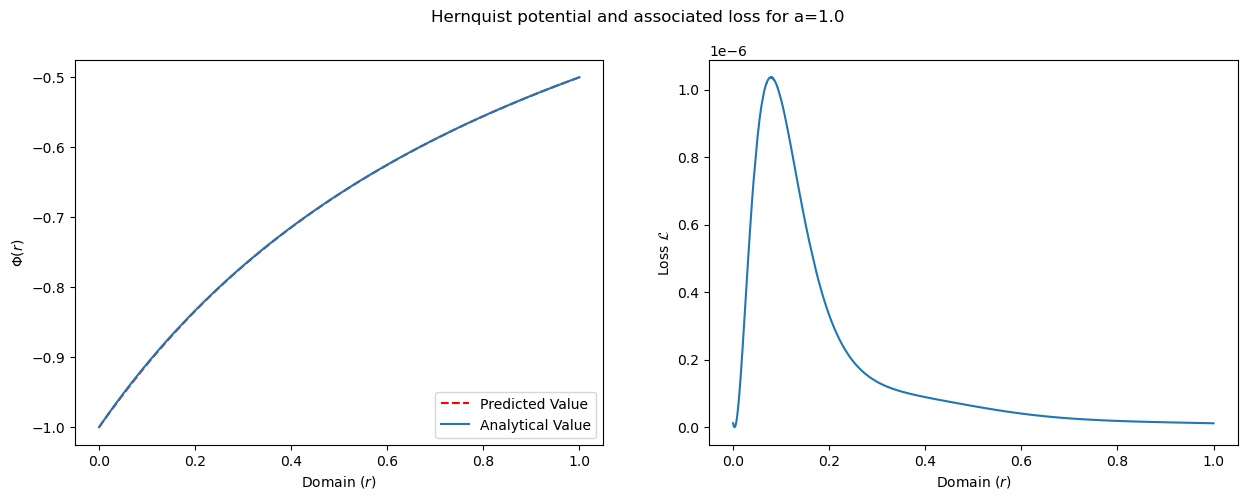

In [33]:
plot_prediction_and_loss(1, save=True)